<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_solve_v101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **NESTO**

In [39]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)

369

In [40]:
all_dirs.sort()

In [41]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.15, seed=99):
    seed_everything(seed)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    return all_dirs[n_val:], all_dirs[:n_val]

In [42]:
seed_everything(1)
train_dirs, valid_dirs = shuffle_split(all_dirs)
print(len(valid_dirs), len(train_dirs))

55 314


In [43]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [44]:
# Training transformations
trn_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

# Validation transformations
val_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

In [45]:
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


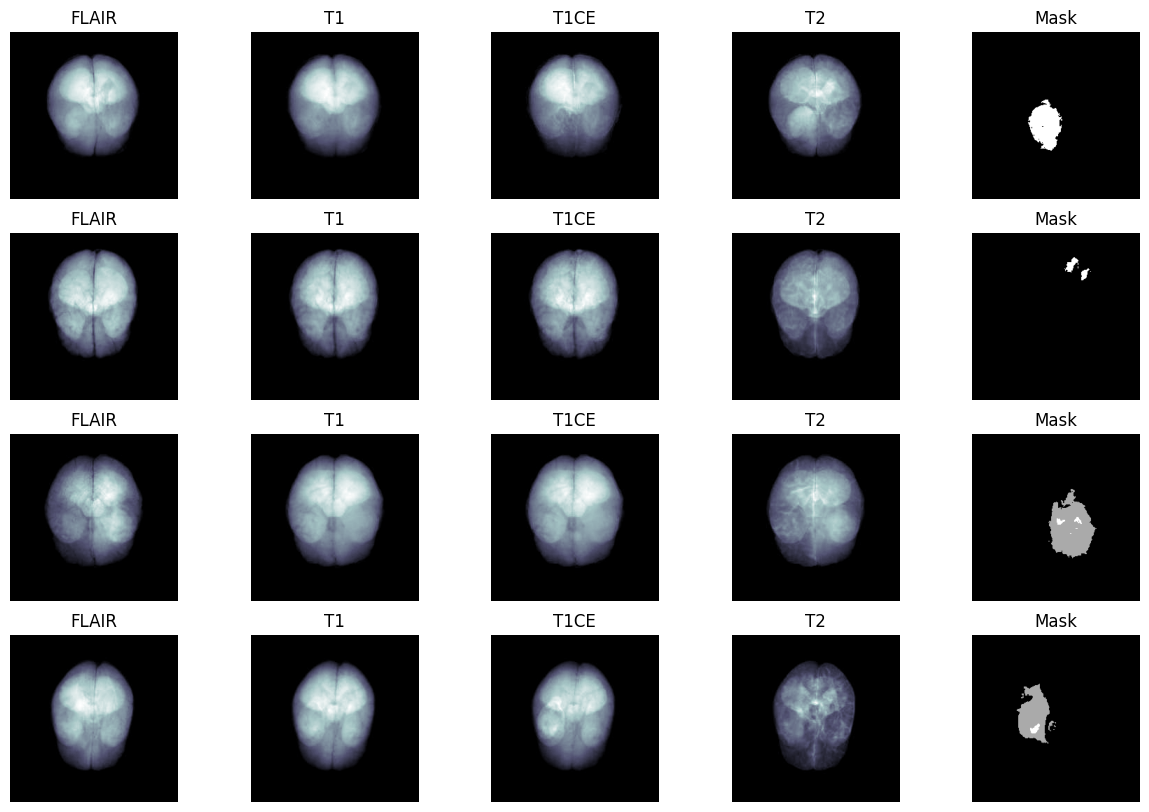

In [46]:
dl_it = iter(train_dl)

# Fetch and display information from the first few batches
for _ in range(4):
    imgs, msks = next(dl_it)
    print(imgs.shape)
    print(msks.shape)

# Shuffle the data
idx = np.random.permutation(imgs.shape[0])
imgs = imgs[idx]
msks = msks[idx]

# Visualize the data
plt.figure(figsize=(15, 10))
for i in range(4):
    for j in range(len(modality_types)):
        plt.subplot(4, 5, 5 * i + j + 1)
        plt.imshow(imgs[i][j], cmap='bone')
        plt.axis('off')
        plt.title(modality_types[j])

    plt.subplot(4, 5, 5 * i + 5)
    plt.imshow(256 - (np.argmax(msks[i], axis=0) * 80), cmap='gray')
    plt.axis('off')
    plt.title('Mask')

In [47]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [48]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

## Klasa koja implementira gubitak temeljen na Dice koeficijentu
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score

## Klasa koja kombinira gubitak binarne unakrsne entropije (BCE) i gubitak temeljen na Dice koeficijentu
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss

## Pomoćne funkcije za test
## Računaju Dice i Jaccard koeficijente za svaku klasu u višeklasnoj segmentaciji
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [49]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch + 1}/{self.num_epochs} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        # Zamijenite for petlju s tqdm
        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

            # Dodano: Ispis metrika za svaku epohu
            if itr % 10 == 0:  # Ispis svakih 10 iteracija
                print(f"Iteration [{itr}/{total_batches}]\tLoss: {loss.item():.4f}")

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"{phase} epoch {epoch + 1}/{self.num_epochs}\tLoss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['razzmatazz', 'raspberry']  # Promijenjene boje
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} | Val Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} | Val Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} | Val Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-light-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()


    ## Učitava unaprijed trenirani model iz pohranjenih težina
    def load_predtrain_model(self, state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)


In [50]:
batch_size = 8

train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)

print(len(valid_dl ), len(train_dl))

7 40


In [51]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
#model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device).float()
model = UNet(n_channels=4, n_classes=4).to(device)

In [52]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  criterion = BCEDiceLoss(),
                  lr = 5e-4,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 50,
                 )

device: cpu


In [53]:
%%time
trainer.run()

train epoch: 1/50 | time: 11:34:48
Iteration [0/40]	Loss: 1.3593


KeyboardInterrupt: 

In [54]:
## Evaluacija modela po klasama, računajući Dice i Jaccard koeficijente za svaku klasu

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            #imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()


            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [55]:
valid_ds = BratsDataset(valid_dirs, modality_types)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)

In [56]:
model.eval();

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, valid_dl, ['WT', 'TC', 'ET', 'BG'])

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

In [ ]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
def show_results(model, test_dl, checkpoint_path):


    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    for BB in range(4):
        images, masks = next(dl_iter)
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images.float())

        preds = torch.argmax(outputs, dim=1)
        masks = torch.argmax(masks, dim=1)
        masks = masks * 84
        preds = preds * 84

        mean = 0.5
        std = 0.5
        plt.figure(figsize=(20, 40))

        for i in range(4):
            for j in range(len(modality_types)):
                # show all types of images
                plt.subplot(16, 6, 6 * i + j + 1)
                plt.axis('off')
                plt.title(modality_types[j])
                plt.imshow(images[i][j].cpu(), cmap='bone')

            # show True Mask
            plt.subplot(16, 6, 6 * i + 5)
            plt.title('True Mask')
            plt.axis('off')
            plt.imshow(255 - masks[i].cpu(), cmap='bone')

            # show Predicted Mask
            plt.subplot(16, 6, 6 * i + 6)
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.imshow(255 - preds[i].cpu(), cmap='bone')

        plt.show()


In [ ]:
show_results(model, valid_dl, checkpoint_path = None)